# Semester 5 Intro to Machine Learning Module Mini Project
### Task - Predict the Home loan Credit Risk for each client with limited credit history
### Solution - Trained a model by ensembling catboost and lgbm boost 
### Ranked 1779 among 3856 (top 47%)

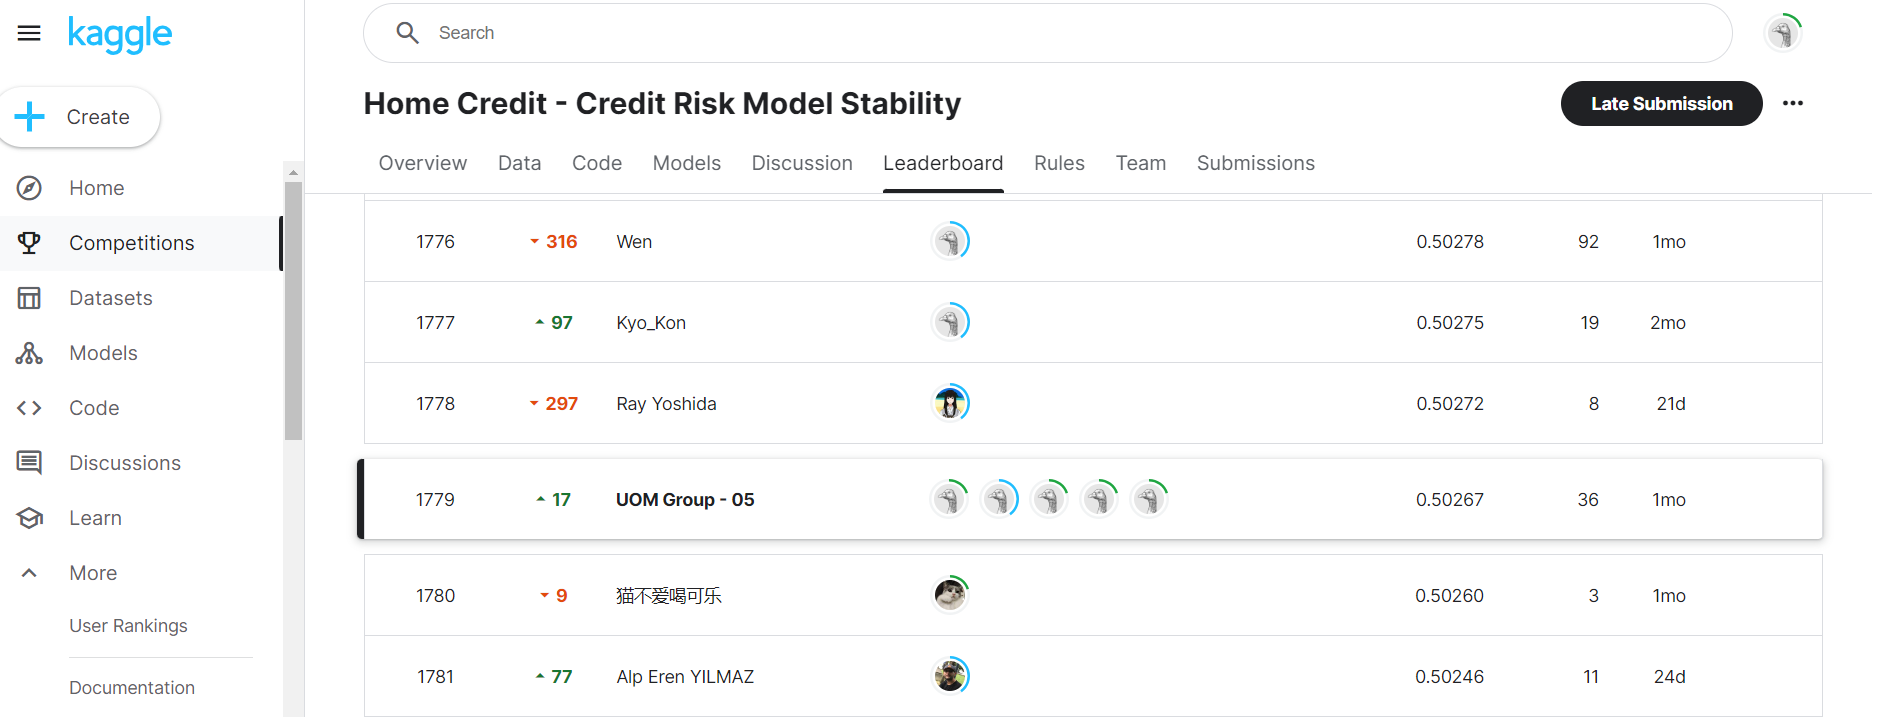

In [ ]:

import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, ClassifierMixin

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Pre-Fitted Voting Model

In [ ]:
class VotingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

### Pipeline

In [ ]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.with_columns(pl.col(col).cast(pl.Float32))
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

### Automatic Aggregation

In [ ]:
class Aggregator:
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max
    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

### File I/O

In [ ]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        
        chunks.append(df)
        
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    
    return df

### Feature Engineering

In [ ]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base

In [ ]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

### Configuration

In [ ]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

### Train Files Read & Feature Engineering

In [ ]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [ ]:
df_train = feature_eng(**data_store)


print("train data shape:\t", df_train.shape)

### Test Files Read & Feature Engineering

In [ ]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [ ]:
df_test = feature_eng(**data_store)

print("test data shape:\t", df_test.shape)

### Feature Elimination

In [ ]:
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

### Pandas Conversion

In [ ]:
df_train, cat_cols = to_pandas(df_train)
df_test, cat_cols = to_pandas(df_test, cat_cols)

### Garbage Collection

In [ ]:
del data_store

gc.collect()

### EDA

In [ ]:
print("Train is duplicated:\t", df_train["case_id"].duplicated().any())
print("Train Week Range:\t", (df_train["WEEK_NUM"].min(), df_train["WEEK_NUM"].max()))

print()

print("Test is duplicated:\t", df_test["case_id"].duplicated().any())
print("Test Week Range:\t", (df_test["WEEK_NUM"].min(), df_test["WEEK_NUM"].max()))

In [ ]:
sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="target",
)
plt.show()

In [ ]:
un_Selected=  df_train.columns-['lastapprcommoditycat_1041M',
 'lastcancelreason_561M',
 'lastrejectcommoditycat_161M',
 'lastrejectcommodtypec_5251769M',
 'lastrejectreason_759M',
 'lastrejectreasonclient_4145040M',
 'max_education_927M',
 'max_empladdr_district_926M',
 'max_empladdr_zipcode_114M',
 'max_language1_981M',
 'max_incometype_1044T',
 'max_role_1084L',
 'max_sex_738L',
 'max_type_25L',
 'case_id',
 'WEEK_NUM',
 'target',
 'weekday_decision',
 'annuity_780A',
 'applications30d_658L',
 'clientscnt_533L',
 'credamount_770A',
 'disbursedcredamount_1113A',
 'homephncnt_628L',
 'mobilephncnt_593L',
 'numactivecredschannel_414L',
 'numcontrs3months_479L',
 'numnotactivated_1143L',
 'numrejects9m_859L',
 'sellerplacecnt_915L',
 'max_birth_259D',
 'max_personindex_1023L',
 'max_persontype_1072L',
 'max_persontype_792L',
 'max_num_group1_9']

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 20,
    "learning_rate": 0.05,
    "n_estimators": 3000,
    "colsample_bytree": 0.8, 
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "device": "gpu",
}

df_train_copy=df_train.copy()
df_train_copy=df_train_copy.dropna(axis=1)
X = df_train_copy.drop(columns=["target", "case_id", "WEEK_NUM"])
y =df_train_copy["target"]


discrete_features=[]
for colname in df_train_copy.select_dtypes(["number"]):
    discrete_features.append(colname)
cor = df_train_copy[discrete_features].corr()


In [83]:
cor_target = abs(cor["target"])
relevant_features = cor_target[cor_target<0.01]
relevant_features
descreate=relevant_features.index

In [84]:
X = df_train_copy.copy()
y = X.pop('target')


X_train_dropppedNa=X.dropna(axis=1)
print(X_train_dropppedNa.shape)
categorical_features=[]

for colname in X_train_dropppedNa.select_dtypes(["object", "category"]):
    X_train_dropppedNa[colname], _ = X_train_dropppedNa[colname].factorize()
    categorical_features.append(colname)


from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X_train_dropppedNa[categorical_features], y)
mutual_info = pd.Series(mutual_info)




(1526659, 62)


In [42]:
mutual_info.index = X_train_dropppedNa[categorical_features].columns

In [50]:
categoraical=mutual_info.index

In [51]:
categoraical

Index(['lastapprcommoditycat_1041M', 'lastcancelreason_561M',
       'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M',
       'lastrejectreason_759M', 'lastrejectreasonclient_4145040M',
       'max_education_927M', 'max_empladdr_district_926M',
       'max_empladdr_zipcode_114M', 'max_language1_981M',
       'max_incometype_1044T', 'max_role_1084L', 'max_sex_738L',
       'max_type_25L'],
      dtype='object')

In [43]:
mutual_info

lastapprcommoditycat_1041M         0.005313
lastcancelreason_561M              0.000714
lastrejectcommoditycat_161M        0.006633
lastrejectcommodtypec_5251769M     0.000060
lastrejectreason_759M              0.045818
lastrejectreasonclient_4145040M    0.000834
max_education_927M                 0.000328
max_empladdr_district_926M         0.000000
max_empladdr_zipcode_114M          0.000100
max_language1_981M                 0.060994
max_incometype_1044T               0.067131
max_role_1084L                     0.134795
max_sex_738L                       0.083214
max_type_25L                       0.000128
dtype: float64

In [54]:
descreate=descreate.tolist()

In [55]:
descreate

['target',
 'weekday_decision',
 'annuity_780A',
 'applications30d_658L',
 'clientscnt_533L',
 'credamount_770A',
 'disbursedcredamount_1113A',
 'homephncnt_628L',
 'mobilephncnt_593L',
 'numactivecredschannel_414L',
 'numcontrs3months_479L',
 'numnotactivated_1143L',
 'numrejects9m_859L',
 'sellerplacecnt_915L',
 'max_birth_259D',
 'max_personindex_1023L',
 'max_persontype_1072L',
 'max_persontype_792L',
 'max_num_group1_9']

In [56]:
categoraical=categoraical.tolist()


In [58]:
categoraical.extend(["case_id", "WEEK_NUM"])

In [59]:
categoraical.extend(descreate)

In [60]:
categoraical

['lastapprcommoditycat_1041M',
 'lastcancelreason_561M',
 'lastrejectcommoditycat_161M',
 'lastrejectcommodtypec_5251769M',
 'lastrejectreason_759M',
 'lastrejectreasonclient_4145040M',
 'max_education_927M',
 'max_empladdr_district_926M',
 'max_empladdr_zipcode_114M',
 'max_language1_981M',
 'max_incometype_1044T',
 'max_role_1084L',
 'max_sex_738L',
 'max_type_25L',
 'case_id',
 'WEEK_NUM',
 'target',
 'weekday_decision',
 'annuity_780A',
 'applications30d_658L',
 'clientscnt_533L',
 'credamount_770A',
 'disbursedcredamount_1113A',
 'homephncnt_628L',
 'mobilephncnt_593L',
 'numactivecredschannel_414L',
 'numcontrs3months_479L',
 'numnotactivated_1143L',
 'numrejects9m_859L',
 'sellerplacecnt_915L',
 'max_birth_259D',
 'max_personindex_1023L',
 'max_persontype_1072L',
 'max_persontype_792L',
 'max_num_group1_9']

In [61]:
df_train=df_train[categoraical]

### Training

In [64]:
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y =df_train["target"]
weeks = df_train["WEEK_NUM"]
clf_models=[]
lgbm_models=[]
cv = StratifiedGroupKFold(n_splits=5, shuffle=False)
# cat_cols = list(df_data.select_dtypes("object").columns)
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 20,
    "learning_rate": 0.05,
    "n_estimators": 3000,
    "colsample_bytree": 0.8, 
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "device": "gpu",
}

fitted_models = []

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)
    
    lgbm=lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(200)]
    )


    lgbm_models.append(lgbm)
   
for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    
    X_train[cat_cols] = X_train[cat_cols].astype(str)
    X_valid[cat_cols] = X_valid[cat_cols].astype(str)

    

    
    train_pool = Pool(X_train, y_train,cat_features=cat_cols)
    val_pool = Pool(X_valid, y_valid,cat_features=cat_cols)
    clf = CatBoostClassifier(
    eval_metric='AUC',
    task_type='GPU',
    learning_rate=0.03,
    iterations=3000)
    random_seed=3107
    clf.fit(train_pool, eval_set=val_pool,verbose=300)
    clf_models.append(clf)
    

model = VotingModel(fitted_models)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 200 rounds
[50]	valid_0's auc: 0.714275
[100]	valid_0's auc: 0.720634
[150]	valid_0's auc: 0.723841
[200]	valid_0's auc: 0.725059
[250]	valid_0's auc: 0.725838
[300]	valid_0's auc: 0.726339
[350]	valid_0's auc: 0.726581
[400]	valid_0's auc: 0.726874
[450]	valid_0's auc: 0.72723
[500]	valid_0's auc: 0.727268
[550]	valid_0's auc: 0.727363
[600]	valid_0's auc: 0.727514
[650]	valid_0's auc: 0.72759
[700]	valid_0's auc: 0.727633



KeyboardInterrupt



### Prediction

In [57]:
X_test = df_test.drop(columns=["WEEK_NUM"])
X_test = X_test.set_index("case_id")
X_test[cat_cols] = X_test[cat_cols].astype(str)
y_preds = [estimator.predict_proba(X_test)[:, 1] for estimator in clf_models]
print(y_preds)
# y_preds=np.array(y_preds)

X_test[cat_cols] = X_test[cat_cols].astype("category")

lgbm_y_preds = [estimator.predict(X_test) for estimator in lgbm_models]
y_preds.extend(lgbm_y_preds)
mean_pred=np.mean(y_preds, axis=0)

y_pred = pd.Series(mean_pred, index=X_test.index)

[array([0.05076083, 0.06221573, 0.03788605, 0.06159255, 0.12215933,
       0.05174049, 0.04929268, 0.03959878, 0.03909221, 0.04670961]), array([0.04994144, 0.06821471, 0.03821128, 0.06073551, 0.12739354,
       0.04561124, 0.05466875, 0.04286793, 0.04683554, 0.04956145])]


In [58]:
y_pred

case_id
57543    0.030187
57549    0.077279
57551    0.022299
57552    0.041220
57569    0.117867
57630    0.028743
57631    0.065115
57632    0.029434
57633    0.059368
57634    0.044781
dtype: float64

### Submission

In [ ]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred

In [ ]:
print("Check null: ", df_subm["score"].isnull().any())

df_subm.head()

In [ ]:
df_subm.to_csv("submission.csv")